<a href="https://colab.research.google.com/github/Bast-94/RL-DQN/blob/dqn-draft/RL-DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de Reinforcement Learning : Deep Q-Learning sur le casse-brique d'Atari

In [101]:
! pip install gymnasium["accept-rom-license"]
! pip install gymnasium["atari"]
! pip install torchviz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=927d9e01fde3705e9456eac8b7fc942a239f69b2a5574a86475ff4c97720901f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


## Présentation globale du projet

### Objectifs du projet

Le but de ce projet est de mettre en place un algorithme d'apprentissage par renforcement basé sur les réseaux de neurones capable de jouer au Casse Brique d'Atari en maximisant ses gains.

### Algorithme principal

L'algorithme de l'agent va être quelque peu différent de ceux vus dans les tavaux précédents (Sarsa, Qlearning). Plusieurs éléments vont compléxifier la tâche:
- Les états sont sous formes d'images de taille $(210,160,3)$ et non plus sous forme numérique.
- La fonction $Q(s,a)$ va faire intervenir un réseaux de neurones $\theta$ qui devra être entraîné.
- Les anciennes expériences devront être stockées dans le but de donner une vérité terrain pour l'entrainement du réseau.

#### Pseudo code de l'algorithme

Le pseudo-code de l'algorithme ci-dessous provient de la publication


$\text{Algorithme de Q-Leearning profond avec répétition d'expérience}$
1. **Initialisation:**
   - Initialiser le réseau de neurones $Q$ avec des poids aléatoires.
   - Initialiser la mémoire de relecture $D$ avec capacité maximale $N$.
   - Initialiser aléatoirement les paramètres d'apprentissage.
   - Initialiser la fonction $Q$ avec des $\theta$ aléatoire.
   - Initialiser $\hat{Q}$ avec $\theta^⁻ = \theta$.

2. **Pour chaque épisode:**
   - Initialiser l'environnement et l'état initial $s_1=\{x_1\}$
   - Appliquer le prétraitement $\phi_1 = \phi(s_1)$
   
   3. **Pour chaque étape $t$ de l'épisode:**
      - Choisir l'action $a_t$ avec la politique $\varepsilon$-greedy
        - $\mathbb{P}(a_t = argmax_a(Q(s_t,a;\theta)) = 1 - \varepsilon$
        - $\mathbb{P}(a_t = \text{random\_sample(}A)) = \varepsilon$
      - Exécuter l'action $a_t$, observer la récompense $r_t$ et l'état suivant $s_{t+1}$
      - Stocker la transition $(s_t, a_t, r_{t}, s_{t+1})$ dans la mémoire de relecture $D$
      - Affecter $s_{t+1}=s_t,a_t,x_{t+1}$
      - Prétraitement de $s_{t+1}$ : $\phi_{t+1}=\phi(s_{t+1})$
      - Échantillonner un lot aléatoire de transitions $(s_i, a_i, r_i, s_{i+1})$ de $D$
      - Calculer la vérité terrain $y_i$ pour chaque transition $(s_i, a_i, r_i, s_{i+1})$ en utilisant le réseau $\hat{Q}$ aux paramètre $\theta^-$
      - Cloner $Q$ dans $\hat{Q}$ toutes les $C$ étapes
      


#### Détails des variables
- $Q$ : Fonction de qualité qui pour un couple état-action évalue à quel point une action dans un état donné est favorable.
- $C$ : Nombre d'étapes à laquelle $\hat{Q}$ se met à jour sur $Q$.
- $\hat{Q}$ : Target Network , il correspond à une version ancienne de $Q$ avec des paramètres $\theta^-$ sur les $C$ dernières étapes.
- $\theta$ : Correspond aux paramètres du réseau de neurones.
- ${A}$ : L'ensemble des actions possibles.
- $a_t$ : L'action faite par l'agent à l'étape $t$.
- $x_t$ : Correspond à l'image brut du jeu à l'étape $t$.
- $s_t$ : Correspond à une séquence de couples action-image $\{a_i \times x_i\}_{i\lt t}$ .
- $\phi_t$ : Correspond au pré-traitement de l'état $s_t$ (Plus de détails dans la suite du notebook).
- $\varepsilon \in [0,1]$ : Probabilité de choisir une action aléatoire.
- $r_t$ : Récompense obtenue par la réalisation de l'action $a_t$ à l'instant $s_t$
- $D$ : Mémoire de relecture.
- $N$ : Nombre de simulations.

## Démarche de recherche et implémentation

In [65]:
# Importation pour la création des réseaux de neurones
from torch import nn
import torch
import torchvision.transforms as transforms

# Librairie dédiée à la simulation du Casse-Brique
import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from time import time
from collections import namedtuple
# Librairie dédiée à la création des gif finaux
from PIL import Image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Prétraitement des données

Le prétraitement des données se justifie par le fait que l'entrainement des des réseaux de neurones nécessite d'enregistrer les états précédents. Les états correspondent ici à une image du jeux sous frome de tableau de dimension $\text{(hauteur,largeur,nombre de canaux)}$. Afin de réduire le coût en mémoire il faut réduire la taille de chaque état en les prétraitant et en conservant l'information. L'interface du casse-brique d'Atari est très pixelisée et redondante en terme de couleurs, il est donc possible de pouvoir faire une réduction de dimension au niveau de la couleur et de la taille de l'image

In [17]:
def preprocess_image(img_array:np.array) -> np.array :
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((84, 84)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor()])
  return transform(img_array)


Ainsi l'image passera d'une shape $(210,160,3)$ à une shape $(84,84,1)$ réduisant considérablement la taille.

(0.0, False, False, {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4})
new_img.size() = torch.Size([1, 84, 84])


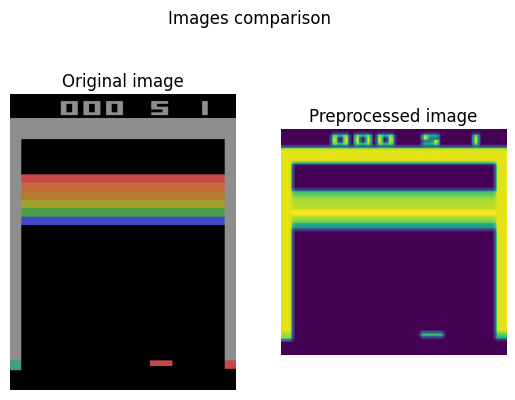

In [18]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
state_img = env.reset()[0]
print(env.step(1)[1:])
fig,axes = plt.subplots(1,2)
fig.suptitle('Images comparison')
axes[0].set_title('Original image')
axes[0].imshow(state_img)
axes[0].axis('off')
new_img = preprocess_image(state_img)
print(f'{new_img.size() = }')
axes[1].axis('off')
axes[1].set_title('Preprocessed image')
axes[1].imshow(new_img.permute(1,2,0))

In [93]:
Input = namedtuple('input', ('height', 'width', 'n_action'))

def get_input_shapes(env:gym.Env):
  env_tensor = np.zeros(env.observation_space.shape,dtype=np.uint8)
  x = preprocess_image(env_tensor)
  _,height, width = x.shape
  n_action=env.action_space.n
  return Input(height,width,n_action)



### Elaboration de modèles de de DQN

Ici deux modèles vont être implémentés pour étudier quelle est la stratégie la plus adaptée.

#### DQN simple

In [91]:
class DQN(nn.Module):
    def __init__(self, n_action, height, width, linear_size=1024, model_name=None):
        super(DQN, self).__init__()
        self.input_dimension = 1, height, width

        self.conv1 = nn.Conv2d(in_channels=self.input_dimension[0], out_channels=64, kernel_size=8, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        x0 = torch.zeros(1, 1, height, width)
        x0 = self.convolute(x0)
        x0 = self.flatten(x0)
        flatten_dim = x0.shape[1]

        self.linear1 = nn.Linear(flatten_dim, linear_size)
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(linear_size, n_action)

    def flatten(self, x):
        return x.view(x.shape[0], -1)

    def convolute(self,x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.conv3(x)
      x = self.relu3(x)
      return x

    def forward(self, x):
      x = self.convolute(x)

      x = self.flatten(x)

      x = self.linear1(x)
      x = self.relu4(x)
      return self.linear2(x)

In [ ]:
from torchviz import make_dot


In [92]:


class DuellingDQN(nn.Module):
    def __init__(self, n_action, height, width, linear_size=1024, model_name=None):
        super(DuellingDQN, self).__init__()
        self.input_dimension = 1, height, width
        self.model_name = model_name
        self.conv1 = nn.Conv2d(in_channels=self.input_dimension[0], out_channels=64, kernel_size=8, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        x0 = torch.zeros(1, 1, height, width)
        x0 = self.convolute(x0)
        x0 = self.flatten(x0)
        flatten_dim = x0.shape[1]
        self.value = nn.Linear(flatten_dim,1)
        self.advantage = nn.Linear(flatten_dim,n_action)



    def flatten(self, x):
        return x.view(x.shape[0], -1)

    def convolute(self,x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.conv3(x)
      x = self.relu3(x)
      return x

    def forward(self, x):
      x = self.convolute(x)
      x = self.flatten(x)
      value = self.value(x)
      advantage = self.advantage(x)
      q_value = value + (advantage - advantage.mean(dim=1,keepdim=True))
      return q_value

testons

In [94]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
input_data = get_input_shapes(env)
dqn = DQN(input_data.n_action,input_data.height,input_data.width)
duelling_dqn = DuellingDQN(input_data.n_action,input_data.height,input_data.width)
x = preprocess_image(env.reset()[0])
x = x.unsqueeze(0)
for model in [dqn, duelling_dqn]:
  output = model(x)
  assert output.size(1) == env.action_space.n, print(f'{output.size(1)} != {env.action_space.n}')
  print("Les shapes de sortie du modèle sont cohérentes.")
  print(f'{output.size()}')

Les shapes de sortie du modèle sont cohérentes.
torch.Size([1, 4])
Les shapes de sortie du modèle sont cohérentes.
torch.Size([1, 4])


#### Gestion de la mémoire des expériences

In [95]:
GameTransition = namedtuple('game_transition', ('initial_state', 'action', 'reward','next_state', 'done'))

In [96]:
class ExpStack(): # D
  def __init__(self, max_size:int):
    self.transitions = []
    self.max_size = max_size # N
    self.index = 0

  def enqueue(self,transition:GameTransition):
    if (len(self.transitions) < self.max_size):
      self.transitions.append(transition)
    else:
      self.transitions[self.index] = transition
    self.index +=1
    self.index = self.index % self.max_size

  def get_experiences(self,nb_exp=1):
    return random.sample(self.transitions, nb_exp)

  def __len__(self):
    return len(self.transitions)

  def __getitem__(self,index):
    return self.transitions[index]

  def sample_minibatch(self,batch_size:int=32):
    if (batch_size>=len(self)):
      return self.transitions

    return random.sample(self.transitions, batch_size)

  def tensor_batch(self,batch_size):
    batch = self.sample_minibatch(batch_size)
    batch = GameTransition(*(zip(*batch)))

    initial_state = torch.cat(batch.initial_state, dim=0)
    initial_state = initial_state.unsqueeze(1)

    next_state = torch.cat(batch.next_state, dim=0)
    next_state = next_state.unsqueeze(1)

    reward = torch.tensor(batch.reward)
    reward = reward.unsqueeze(1)

    done = torch.tensor(batch.done).float()
    done = done.unsqueeze(1)

    action = torch.tensor(batch.action)
    action = action.unsqueeze(1)

    return GameTransition(initial_state,action,reward,next_state,done)

### Lancement du modèle sur l'algorithme **"deep Q-learning with experience replay."** issu de l'article

In [97]:
Action = int
State = torch.Tensor

In [98]:
class DQNAgent():
  max_step = int(1e5)
  epsilon = 0.05
  batch_size = 32
  gamma = 0.9
  time_limit = 3600
  def __init__(self, env: gym.Env, max_experiences:int = int(1e6),update_frequency:int=5, verbose:bool=True, model_file:str=None, model:nn.Module=None):
    self.env = env

    self.model = model
    self.target_model = copy.deepcopy(self.model)
    self.target_model.eval()

    self.experiences = ExpStack(max_size=max_experiences)

    self.verbose = verbose
    self.update_frequency = update_frequency
    self.legal_actions = list(range(env.action_space.n))

    self.loss_evolution = []
    self.optimizer = torch.optim.Adam(self.model.parameters())
    self.loss_func = nn.MSELoss()
    self.begin_time = time()
    self.stop = False
    self.epoch_count = 0
    self.frames = []
    if (model_file is None):
      self.model_file = 'model.pt'
    else:
      self.model_file = model_file

  def train_agent(self,nb_episodes:int):
    episode_index = 0
    self.reboot_timer()
    self.clear_saving()
    while(episode_index < nb_episodes and not self.stop):
      total_reward = self.play()
      episode_index +=1

      self.log(f'{episode_index} is done')
      self.log(f'Total reward {total_reward}')


  def play(self,train:bool = True,record_frames:bool =False):
    done = False
    step_index = 0
    current_state = self.env.reset()[0]
    self.frames.append(current_state)
    current_state = preprocess_image(current_state)
    total_reward = 0
    while(step_index <self.max_step and not done and not self.stop):
      # Initialize State 1 # TODO
      self.update_time()
      #done = self.make_step(current_state)
      a_t = self.get_action(current_state=current_state)
      next_state,reward,done,info,next_state_frame = self.make_action(a_t)
      self.frames.append(next_state_frame)
      total_reward += reward

      if (train):
        transition = GameTransition(current_state,a_t,reward,next_state,done)
        self.experiences.enqueue(transition)

        mini_batch = self.experiences.tensor_batch(self.batch_size)
        self.train_model(mini_batch)
        if(step_index % self.update_frequency == 0):
          self.update_parameters()
      if(done):
        self.log(f'Game over after {step_index} steps')
      current_state = next_state
      step_index +=1
    return total_reward


  def train_model(self,batch:list[GameTransition]) -> None:
    self.model.train()
    y_target = (1 - batch.done ) * self.target_model(batch.next_state) * self.gamma + batch.reward
    y_target = y_target.max(1)[0].unsqueeze(1)
    y_pred = self.model(batch.initial_state).gather(1,batch.action)
    self.gradient_descent(y_target,y_pred)

  def gradient_descent(self,y_target,y_pred):
    loss = self.loss_func(y_target,y_pred)
    self.optimizer.zero_grad()
    loss.backward()
    self.loss_evolution.append(loss.item())
    self.optimizer.step()
    if(self.epoch_count %100 ==0):
      self.log(f'Epoch {self.epoch_count}: loss = {loss.item()}')
    self.epoch_count +=1

  def make_action(self, action: Action) -> tuple[State,float, bool,dict,np.array]:
    state,reward,truncated, terminated,info = self.env.step(action)
    next_state = preprocess_image(state)
    done = truncated or terminated

    return next_state,reward,done,info,state


  def get_action(self,current_state: State) -> Action:
    if(random.random() < self.epsilon):
      return random.choice(self.legal_actions)

    current_state = current_state.unsqueeze(0)
    model_output = self.model(current_state)
    action = model_output.argmax().item()
    return action

  def update_parameters(self) -> None:
    self.target_model = copy.deepcopy(self.model)
    self.target_model.eval()

  def reboot_timer(self):
    self.begin_time = time()
    self.stop = False

  def clear_saving(self):
    self.frames = []
    self.experiences = ExpStack(self.experiences.max_size)
    self.loss_evolution = []

  def generate_gif(self, output_file:str) -> None:
    self.play(train=False)
    frames = [Image.fromarray(f, mode='RGB') for f in self.frames]
    frames[0].save(output_file, format='GIF', append_images=frames[1:], save_all=True, duration=10, loop=0)
    self.log(f'Saving {output_file}')

  def log(self, *args,**kwargs):
    if(self.verbose):
      print(*args,**kwargs)

  def update_time(self):
    current_time = int(time())
    delta = current_time - self.begin_time
    self.stop = delta > self.time_limit
    if(self.stop):
      # Save model
      torch.save(self.model,self.model_file+'.pt')
      self.log(f'TIME OUT: Model stops training after {delta:.2f} seconds, Save model to {self.model_file}.pt')
      self.log(f'Epochs {self.epoch_count}')

In [100]:
def train_agent_and_plot(env_name, model_type, num_episodes=25000,time_limit:int = 3600):
    env = gym.make(env_name, render_mode="rgb_array")
    input_data = get_input_shapes(env)

    model = None
    if model_type == 'simple_dqn':
        model = DQN(input_data.n_action, input_data.height, input_data.width)
    elif model_type == 'duelling_dqn':
        model = DuellingDQN(input_data.n_action, input_data.height, input_data.width)

    agent = DQNAgent(env, verbose=True, model_file=model_type, model=model)
    agent.time_limit = time_limit
    agent.train_agent(num_episodes)
    agent.generate_gif(model_type+'.gif')
    return agent


agents = []
env_name = 'ALE/Breakout-v5'
model_types = ['simple_dqn', 'duelling_dqn']
TIME_LIMIT = 3600


for  model_type in (model_types):
    agent = train_agent_and_plot(env_name, model_type,time_limit=TIME_LIMIT)
    agents.append(agent)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for agent,ax,model_type in zip(agents,axes,model_types):

    ax.plot(agent.loss_evolution, label=agent.model_file,color='blue')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss value')
    ax.set_title(f'Loss evolution for {model_type}')
    ax.legend()

plt.show()
fig.savefig('combined_loss.png')

Epoch 0: loss = 8.112925570458174e-06
Epoch 100: loss = 5.522559263226867e-07
Game over after 160 steps
1/25000 episodes are done
Epoch 200: loss = 8.475968371612908e-09
Epoch 300: loss = 1.8201435025844148e-08
Game over after 166 steps
2/25000 episodes are done
Epoch 400: loss = 5.161574517842382e-05
Epoch 500: loss = 0.00012095828424207866
Game over after 251 steps
3/25000 episodes are done
Epoch 600: loss = 1.886272457340965e-06
Epoch 700: loss = 2.7888716431334615e-05
Epoch 800: loss = 4.02447449232568e-06
Epoch 900: loss = 2.6376555979368277e-05
Epoch 1000: loss = 8.478105542053527e-07
Epoch 1100: loss = 7.657100468350109e-06
Epoch 1200: loss = 7.908413681434467e-05
Game over after 624 steps
4/25000 episodes are done
Epoch 1300: loss = 1.5518149893978261e-06
Epoch 1400: loss = 2.0683390175690874e-05
Epoch 1500: loss = 9.188781405100599e-06
Epoch 1600: loss = 3.8430782296927646e-05
Game over after 413 steps
5/25000 episodes are done
Epoch 1700: loss = 3.4386594052193686e-05
Epoch 1

KeyboardInterrupt: ignored

[](./simple_dqn.gif)